# 6 - Advanced simulations of a 2D Ising model
To address the problem of ”quasi-ergodicity”, the ”multiple Markov chains” (MMC) algorithm
was introduced.  Also referred to as "parallel tempering," MMC synchronizes the progression of multiple Markov chains.<br>

Usually, these chains operate at distinct temperatures within a system sharing identical parameters. Each Markov chain independently evolves configurations until a swap move is initiated. This action allows for the exchange of configurations between chains while maintaining a global detailed balance condition.
Main advantages of MMC: 
  1. In the MMC algorithm, each chain undergoes a random walk through temperature space. Periodically, these chains reach high temperatures, where they quickly evolve. Then they stochastically transition back to lower temperatures. <br>
  In contrast, single chains operating solely at low temperatures tend to struggle with decorrelation and frequently become trapped within local energy minima.

2. Another advantage of the MMC approach is the simultaneous achievement of sampling at various temperatures, a requirement often essential for evaluating thermodynamic properties.

### Implementation 
To **allocate memory** for energies, magnetizations, spins for each chain I first create 3 vectors of pointers to double precision floating-point numbers 

``` 
    vector<double*> E(n_chains, nullptr);
	vector<double*> M(n_chains, nullptr);
	vector<double*> spins(n_chains, nullptr);

```
Then I **initialize the chains** by allocating for each E[i] (Energy for the chain i, in the image the horizontal vectors) the space for a chain of lenght `burnInSteps + nsteps + 1`.
```
	for (int i = 0; i < n_chains; ++i) {
		E[i] = new double[burnInSteps + nsteps + 1];
		M[i] = new double[burnInSteps + nsteps + 1];
		spins[i] = new double[nx * ny];
    }
```
At the end the object `E` contains n_chains vectors, each of lenght (burnInSteps + nsteps + 1); in practice E contains all the trajectories of the energies for all the chains. Similarly for `M` and `spins`:

<img src="scheme_MMC.png" alt="Alt text" width="600" height="600">


Another important vector is the vector of the **configurations**. It tracks in which configuration each chain is at a fixed timestep:
```
        vector<double*> configPointers(n_chains, nullptr);
        for (int i = 0; i < n_chains; ++i) {
        	configPointers[i] = spins[i];          
    	}
```      
When swapping chain we just swap this configuration pointers $ I_k \leftrightarrow I_{k'}$

Let us define now the mechanism of the **attempt swaps between adjacent chains**. 
I keep track of the chain that have already been swapped in the current timestep with the boolean vector `chain_swapped`, defined as: 
   ```
   vector<bool> chain_swapped(n_chains, false).
   ```
At each timestep we attempt to swap chains n_chains times, so that every chain has the possibility to change state. The **swapping algorithm** proceeds as follows: 

1) We select the index $k_1, k_2$ of the 2 adjacent chain to be swapped in this way
```
    k1 = uniform_swap(mt_generator);
    
    u = uniform_dist(mt_generator);
    if (u < 0.5) {
        k2 = k1 + 1; 
    } else {
        k2 = k1 - 1; 
    }
    
```
taking care also of the limit cases ($k_1$ = 0 or $k_1$ = n_chains).

2) we then check if both k1 and k2 are not in the list of swapped chains;
3) we swap between the 2 chains with acceptance probability:
```
acceptance_prob = exp((beta_list[k1] - beta_list[k2]) * diff_ene);
```

## 6.2 Exercise - Multiple Markov Chains
Implement multiple Markov chains for the Ising model. Check if the energy distributions of adjacent chains
are overlapped. Record the swapping rate between chains. Compare the autocorrelation times of the chains
when the swapping is allowed and when it is not (thus making the Markov chains effectively single ones).

####  Energy distributions of adjacent chains

| Parameter     | Value                  |
|---------------|------------------------|
| Nx            | 80                     |
| Ny            | 80                     |
| N chains    | 9                   |
| betas         | [0.56, 0.37]    |
| N steps       | 1e4                   |
| N burnt in    | 0                   |
| Max swaps     | 4                      |
| Spin initialization    | All 1                  |



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

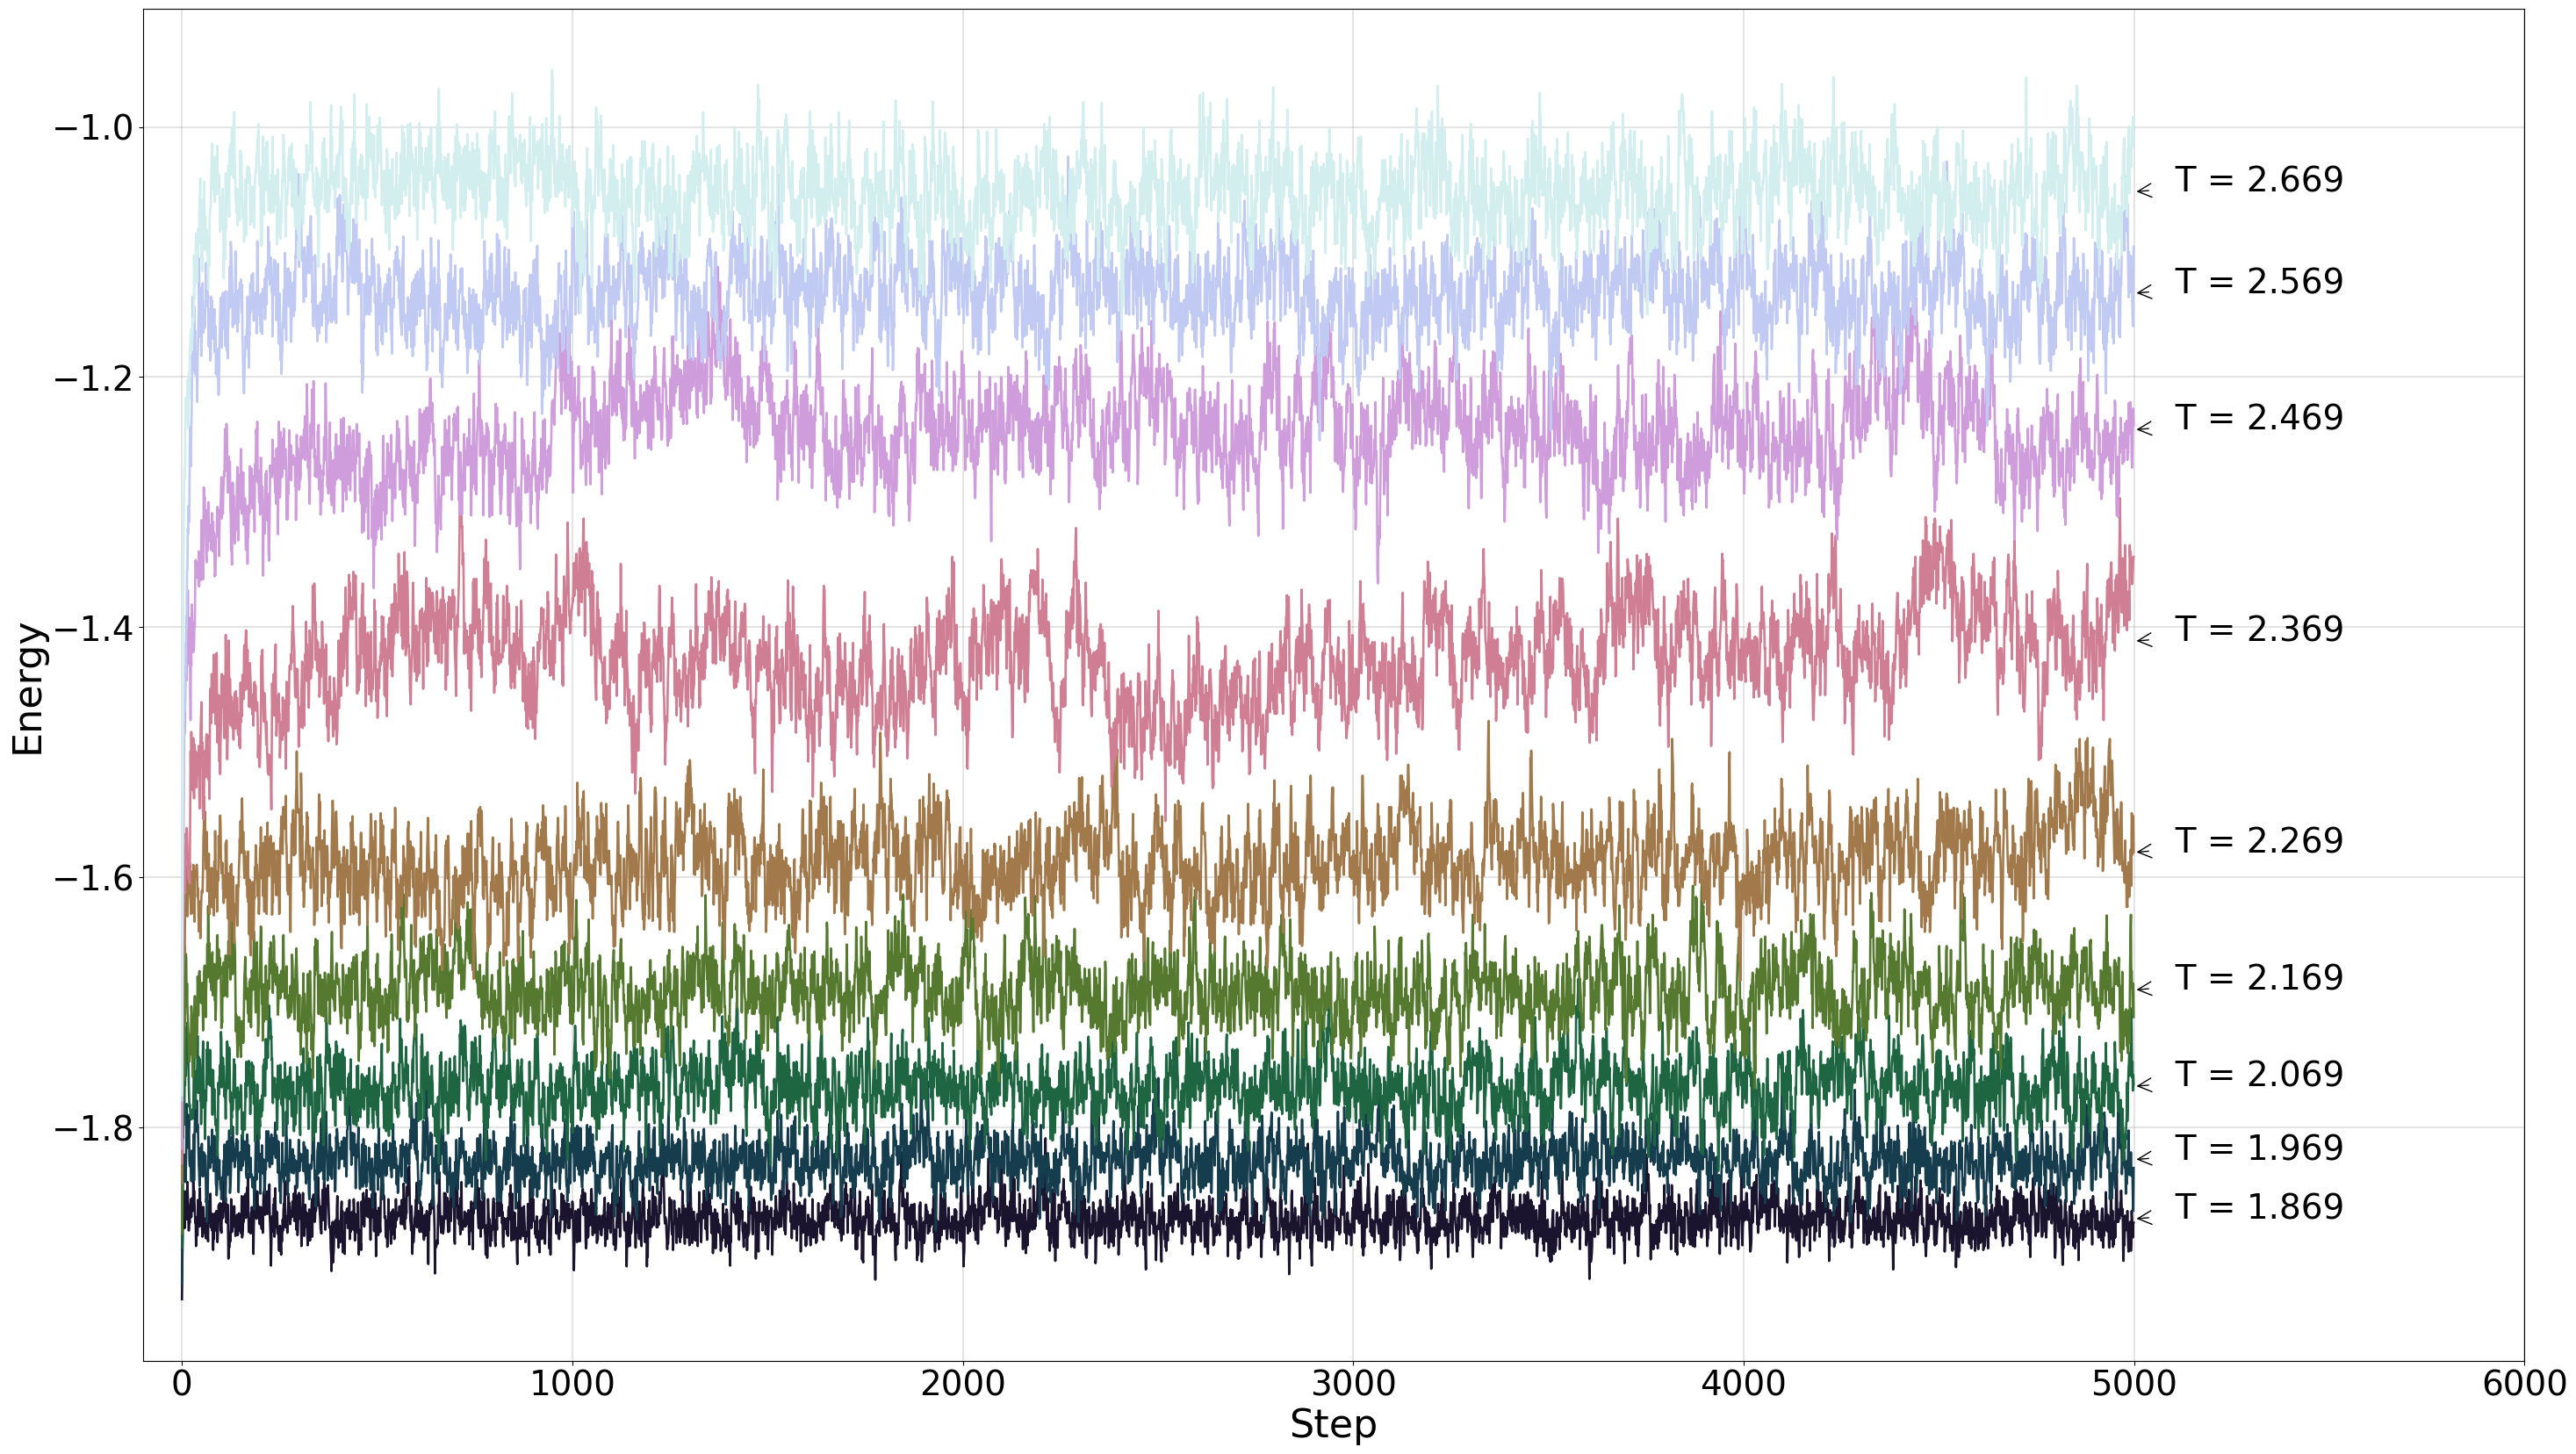

In [2]:
# Define the temperatures of the chains
T_critic = 2.0/np.log(1.0 + np.sqrt(2.0));
betas = np.array([0.56523191, 0.53499243, 0.50782422, 0.48328199, 
                  0.46100257, 0.44068679, 0.42208602, 0.40499188, 
                  0.38922844, 0.37464615])
T = 1/betas

# Load the chains of the n_chains - energies
last_step = 5000
E = np.loadtxt('E_9_80_Tc2.txt')[:last_step]

# Plot the energy chain for every temperature
fig, ax1 = plt.subplots(figsize=(35, 20))
colors = sns.color_palette("cubehelix",n_colors=9)
for i in range(1,10):
    ax1.plot(E[:, 0], E[:, i], label=f'T = {T[i-1]:.2f}', color=colors[i-1], linewidth = 1.9)
    ax1.set_xlim(-100,last_step+1000)
    
    # Annotate temperature near the last value of the energy array
    avg_energy = np.mean(E[3000:last_step, i])
    last_temperature = T[i]
    ax1.annotate(f'  T = {last_temperature:.3f}', xy=(last_step, avg_energy), xytext=(last_step + 50, avg_energy),
                 fontsize=28, arrowprops=dict(facecolor='black', arrowstyle=' ->'))

ax1.set_xlabel('Step',fontsize=32)
ax1.set_ylabel('Energy',fontsize=32)
ax1.tick_params(axis='both', which='major', labelsize=28)
#ax1.legend(fontsize=25)
ax1.grid('--', color = 'gray', linewidth = 0.3)
plt.show()

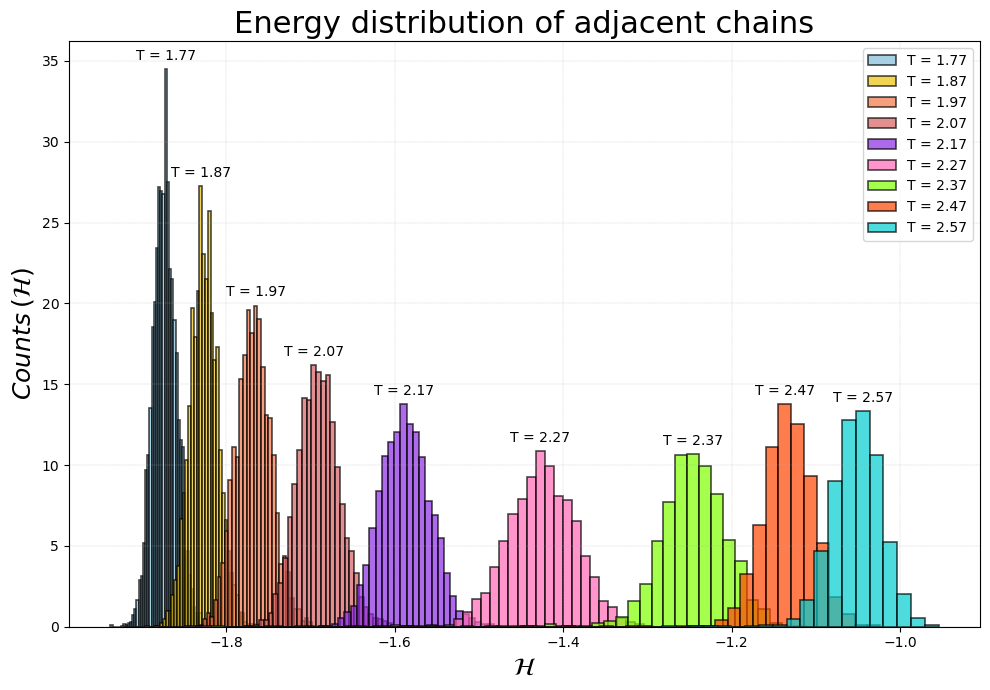

In [3]:
def annotate_maxima(hist, bins, label):
    if label == 'Tc':
        max_index = np.argmax(hist[5:])
    else:
        max_index = np.argmax(hist)
    max_value = hist[max_index]
    bin_center = bins[max_index] + (bins[1] - bins[0]) / 2
    plt.annotate(f"{label}", xy=(bin_center, max_value),
                 xytext=(bin_center + 0, max_value + 0.4),  # Adjust offset for better placement
                 ha='center', va='bottom', fontsize=10)

# Assuming E and T are already defined arrays
# Energy distribution, histograms
colors = ['#067bc2', '#84bcda', '#ecc30b', '#f37748', '#d56062', 
          '#8a2be2', '#ff69b4', '#7fff00', '#ff4500', '#00ced1']
n_bins = 50
plt.figure(figsize=(10, 7))

for i in range(1, 10):
    counts, bins, _ = plt.hist(E[:, i], label=f'T = {T[i-1]:.2f}', density=True, 
                               bins=n_bins, facecolor=colors[i], 
                               edgecolor='black', alpha=0.7, lw=1.2)
    annotate_maxima(counts, bins, f'T = {T[i-1]:.2f}')

plt.title(f'Energy distribution of adjacent chains', fontsize=22)
plt.legend()
plt.grid(ls='--', lw=0.2)
plt.xlabel(r'$\mathcal{H}$', fontsize=18)
plt.ylabel(r'${Counts}\:(\mathcal{H})$',fontsize=18)
plt.tight_layout()
plt.show()


#### Swapping rate between chains

| Parameter     | Value                  |
|---------------|------------------------|
| Nx            | 80                     |
| Ny            | 80                     |
| N chains      | 9                      |
| betas         | [0.56, 0.37]   |
| N steps       | 1e4                    |
| N burnt in    | 0                      |
| Max swaps     | 4                      |
| Spin initialization    | All 1         |

On average, the swapping rate between chains is 0.00198, with  10  chains


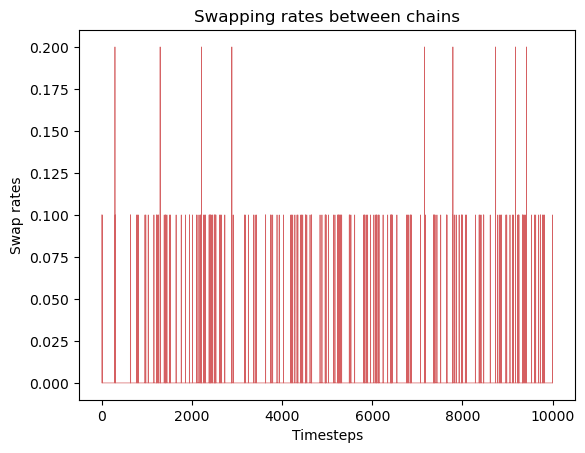

In [4]:
# load data
n_chains = 10
swap_rates = np.loadtxt('swap_rate.txt') / n_chains

# plot
plt.plot(swap_rates,color=colors[4], linewidth = 0.5)
plt.title("Swapping rates between chains")
plt.xlabel("Timesteps")
plt.ylabel("Swap rates")

mean_swap_rate = np.mean(swap_rates)
print(f"On average, the swapping rate between chains is {mean_swap_rate:.5f}, with ", n_chains, " chains")
      

#### Autocorrelation times of chains varing the temperature, at L=120

For the MMC algorithm we consider a set of 9 inverse temperature, in which the 5-th corresponds to the critical temperature:
```
vector<double> beta_list = {0.56523191, 0.53499243, 0.50782422, 0.48328199, 0.46100257, 0.44068679, 0.42208602, 0.40499188, 0.38922844, 0.37464615};
```
    

| Parameters                 |                                 |
|-----------------------------------|---------------------------------|
| L                                 |   120         |
| J                                 |   1                             |
| $k_BT$                            |   10 values around $ T_c$                        |
| $N_{steps}$                       |    10^4                         |
| swap every                        |   [5,6,10,10]                   |


In [5]:
from statsmodels.tsa.stattools import acf, pacf

M_MMC = np.array(np.loadtxt('MMC swap/M_9_120_Tc2.txt'))
M_MMC_NS = np.array(np.loadtxt('MMC no swap/M_noswap_120_Tc.txt'))

temperatures = np.array([0.56523191,0.53499243, 0.50782422, 0.48328199, 
                         0.46100257, 0.44068679, 0.42208602, 0.40499188, 
                         0.38922844, 0.37464615])

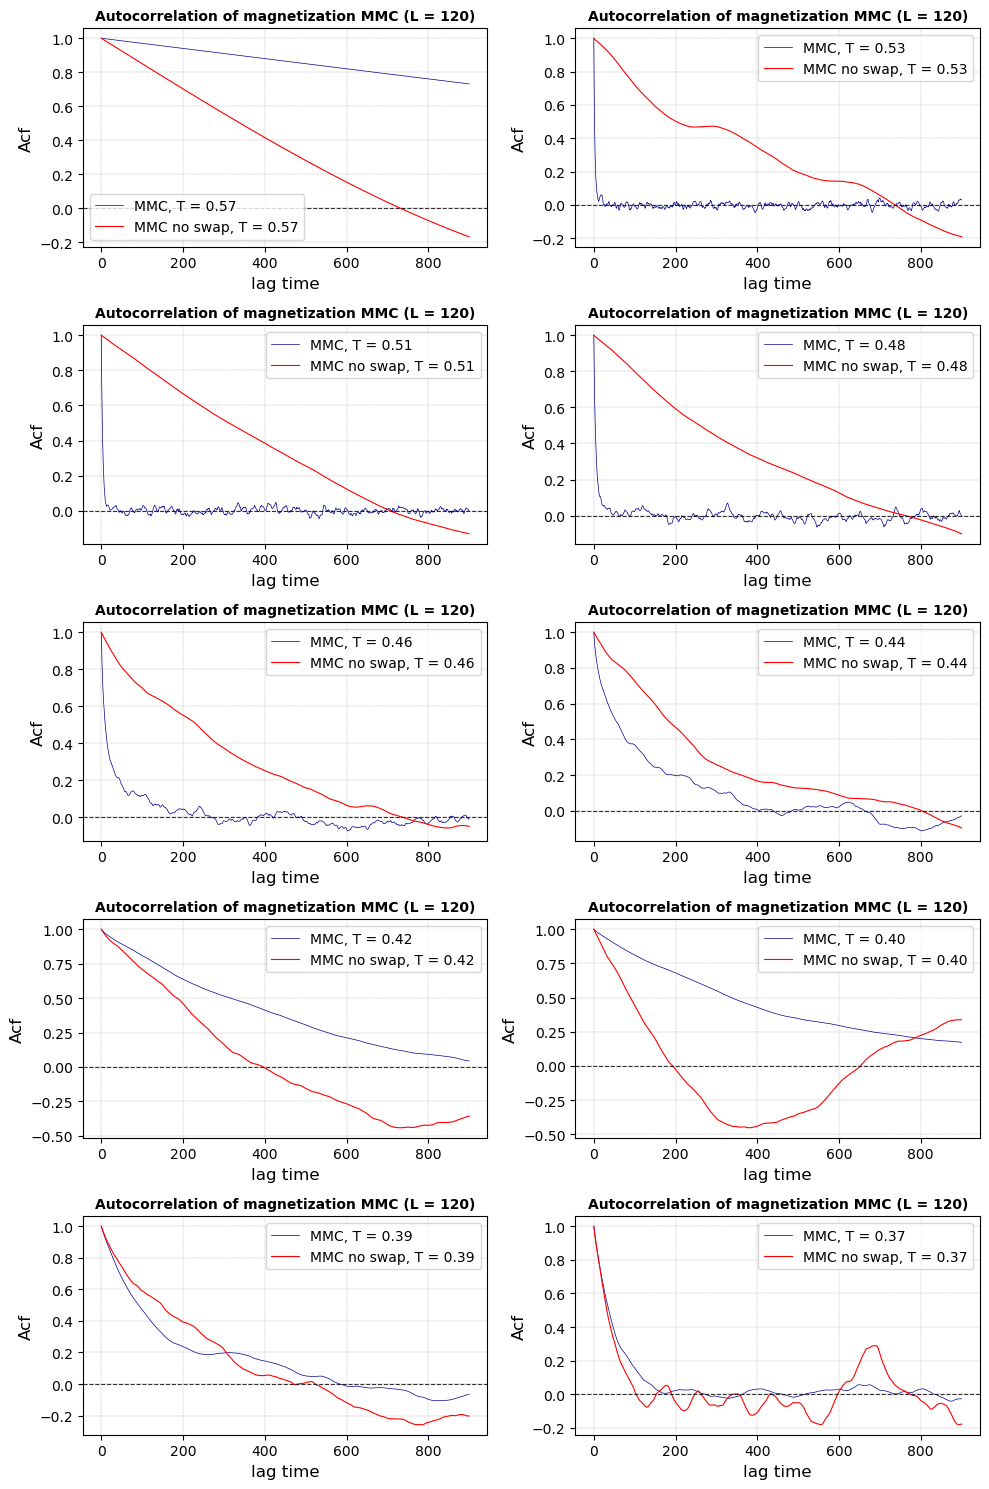

In [6]:
corr_MNS = []
corr_MC = []
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i, ax in enumerate(axes.flatten()):
    tmpC = acf(M_MMC[:,i], nlags=900, fft=False)
    tmpNS = acf(M_MMC_NS[:,i], nlags=900, fft=False)
    corr_MNS.append(tmpNS)
    corr_MC.append(tmpC)
    
    ax.plot(tmpC, label=f'MMC, T = {temperatures[i]:.2f}', color='darkblue', linewidth=0.5)
    ax.plot(tmpNS, label=f'MMC no swap, T = {temperatures[i]:.2f}', color='red', linewidth=0.8)
    ax.set_title(f'Autocorrelation of magnetization MMC (L = 120)', fontsize=10, fontweight="bold")
    ax.set_xlabel('lag time', fontsize=12)
    ax.set_ylabel('Acf', fontsize=12)
    ax.axhline(0, c="black", linestyle="--", linewidth=0.8, alpha=0.8)
    ax.grid(linestyle='--', linewidth=0.2, color='grey')
    ax.legend()

plt.tight_layout()
plt.show()

In [7]:
# compue the integrated autocorrelation time (method 2 in slides)
tau_list_MNS = []
tau_list_MC = []
for i in range(1,10):
    tau_list_MNS.append(np.sum(corr_MNS[i]/corr_MNS[i][0]))
    tau_list_MC.append(np.sum(corr_MC[i]/corr_MC[i][0]))
    

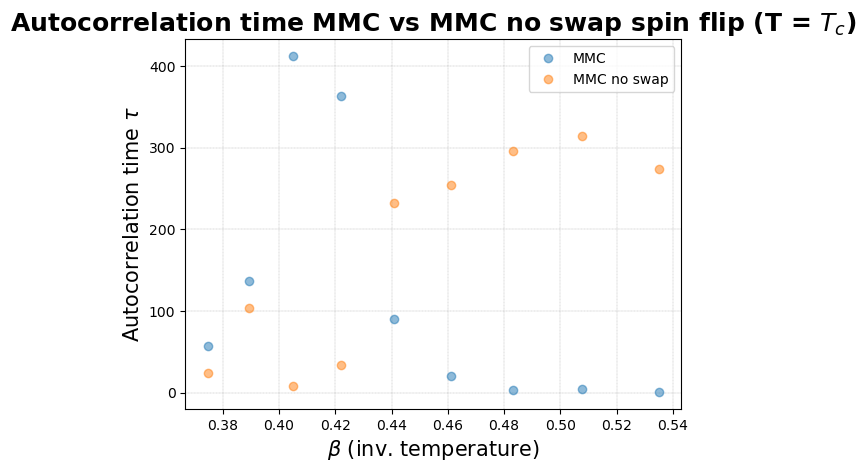

In [8]:
# Plot the data points and the fitted lines
plt.plot(temperatures[1:10], tau_list_MC, 'o', alpha=0.5, label=f'MMC')
plt.plot(temperatures[1:10], tau_list_MNS, 'o',alpha=0.5, label=f'MMC no swap')
#plt.yscale('log')
plt.title(r'Autocorrelation time MMC vs MMC no swap spin flip (T = $T_c$)', fontsize=18, fontweight='bold')
plt.xlabel(r'$\beta$ (inv. temperature)', fontsize=15)
plt.ylabel(r'Autocorrelation time $\tau$', fontsize=15)
plt.grid(linestyle='--', linewidth=0.2, color='grey')
plt.legend()
plt.show()


In [9]:
print('\nThe values of τ for each T and MMC with no swap is: \n')
for temperature, tau in zip(temperatures[1:10], tau_list_MNS):
    print(f"beta = {temperature}: τ = {tau:.3f}")



The values of τ for each T and MMC with no swap is: 

beta = 0.53499243: τ = 273.840
beta = 0.50782422: τ = 314.798
beta = 0.48328199: τ = 296.511
beta = 0.46100257: τ = 254.091
beta = 0.44068679: τ = 232.553
beta = 0.42208602: τ = 34.130
beta = 0.40499188: τ = 8.062
beta = 0.38922844: τ = 103.938
beta = 0.37464615: τ = 24.378


In [10]:
print('\nThe values of τ for each T and MMC with swap is: \n')
for temperature, tau in zip(temperatures[1:10], tau_list_MC):
    print(f"beta = {temperature}: τ = {tau:.3f}")



The values of τ for each T and MMC with swap is: 

beta = 0.53499243: τ = 0.925
beta = 0.50782422: τ = 4.884
beta = 0.48328199: τ = 3.416
beta = 0.46100257: τ = 19.969
beta = 0.44068679: τ = 89.980
beta = 0.42208602: τ = 363.313
beta = 0.40499188: τ = 412.521
beta = 0.38922844: τ = 137.274
beta = 0.37464615: τ = 57.568


From the plot of the $\tau$ vs temperature we observe how the MMC model allows to reduce correlation between samples, expecially for $T > Tc$ . Above $Tc$ , samples are overall uncorrelated. Instead, in the case of MMC with no swapping between chains we notice that the values of the integrated autocorrelation time is quite high on average $\approx 200$.

#### Autocorrelation times of chains varing the lattice size, at Tc

For the MMC algorithm we consider a set of 9 inverse temperature, in which the 5-th corresponds to the critical temperature:
```
vector<double> beta_list = {0.56523191, 0.53499243, 0.50782422, 0.48328199, 0.46100257, 0.44068679, 0.42208602, 0.40499188, 0.38922844, 0.37464615};
```
    

| Parameters                |                                 |
|-----------------------------------|---------------------------------|
| L                                 |   [50, 80, 100, 120]            |
| J                                 |   1                             |
| $k_BT$                            |   $ T_c$                        |
| $N_{steps}$                       |    10^4                         |
| swap every                        |   [5,6,10,10]                   |


In [11]:
from statsmodels.tsa.stattools import acf, pacf

M_MMC = [np.array(np.loadtxt('MMC swap/M_9_50_Tc2.txt'))[:,5],
        np.array(np.loadtxt('MMC swap/M_9_80_Tc2.txt'))[:,5],
        np.array(np.loadtxt('MMC swap/M_9_100_Tc2.txt'))[:,5],
        np.array(np.loadtxt('MMC swap/M_9_120_Tc2.txt'))[:,5]]

M_MMC_NS = [np.array(np.loadtxt('MMC no swap/M_noswap_50_Tc.txt'))[:,5],
        np.array(np.loadtxt('MMC no swap/M_noswap_80_Tc.txt'))[:,5],
        np.array(np.loadtxt('MMC no swap/M_noswap_100_Tc.txt'))[:,5],
        np.array(np.loadtxt('MMC no swap/M_noswap_120_Tc.txt'))[:,5]]

lengths = np.array([50,80,100,120])

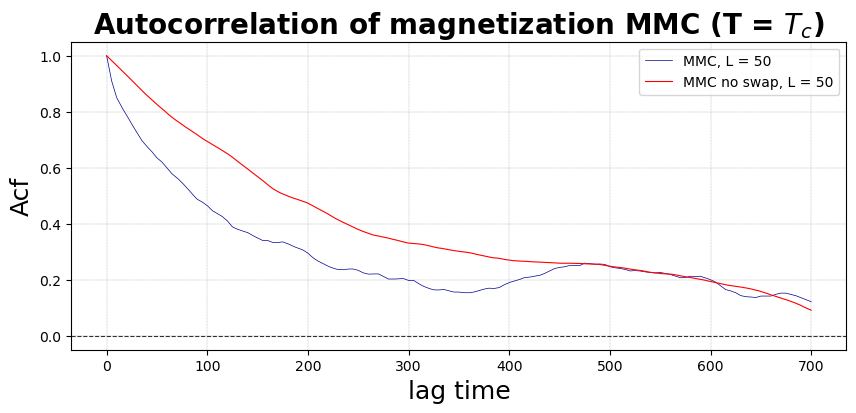

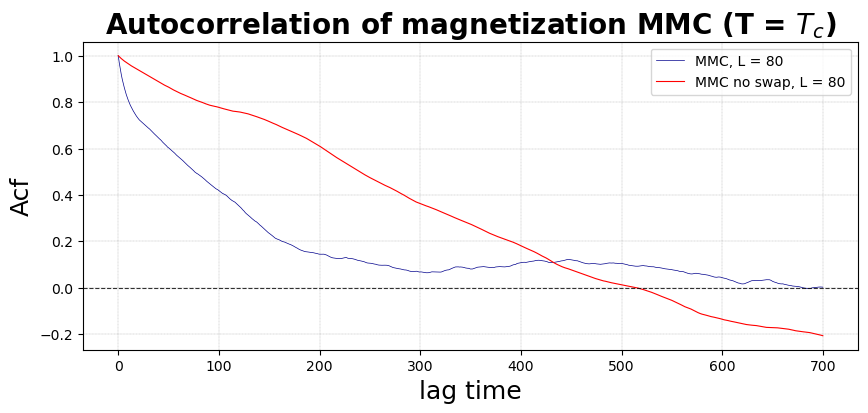

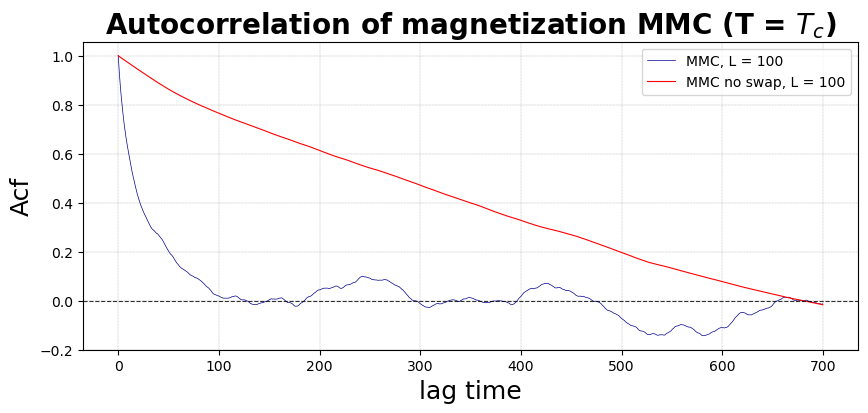

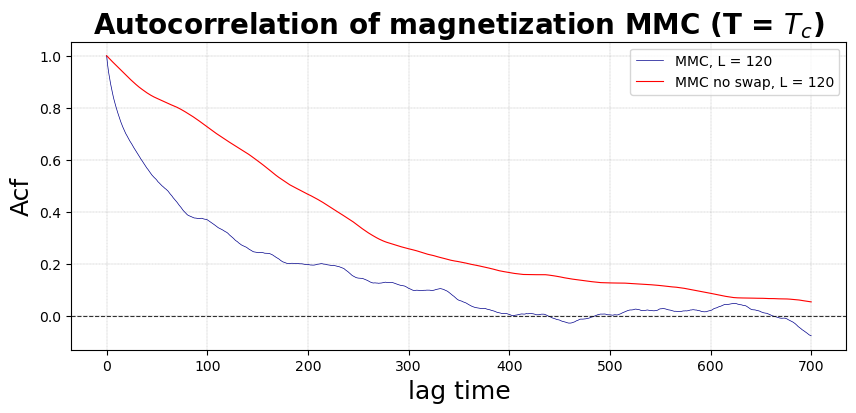

In [12]:
corr_MNS = []
corr_MC = []
for i in range(len(M_MMC)):
    plt.figure(figsize=(10,4))
    tmpC = acf(M_MMC[i][:], nlags=700, fft = False) 
    tmpNS = acf(M_MMC_NS[i][:], nlags=700, fft = False) 
    corr_MNS.append(tmpNS)
    corr_MC.append(tmpC)
    plt.plot(tmpC, label=f'MMC, L = {lengths[i]}', color='darkblue', linewidth=0.5)
    plt.plot(tmpNS, label=f'MMC no swap, L = {lengths[i]}', color='red',linewidth=0.8)
    plt.title(r'Autocorrelation of magnetization MMC (T = $T_c$)', fontsize=20, fontweight = "bold")
    plt.xlabel('lag time', fontsize=18)
    plt.ylabel('Acf', fontsize=18)
    plt.axhline(0, c = "black", linestyle = "--", linewidth = 0.8, alpha = 0.8)
    #plt.xlim([-10,200])
    plt.grid(linestyle = '--', linewidth = 0.2, color='grey')
    plt.legend()
    plt.show()

In [13]:
# compue the integrated autocorrelation time (method 2 in slides)
tau_list_MNS = []
tau_list_MC = []
for i in range(4):
    tau_list_MNS.append(np.sum(corr_MNS[i]/corr_MNS[i][0]))
    tau_list_MC.append(np.sum(corr_MC[i]/corr_MC[i][0]))
    

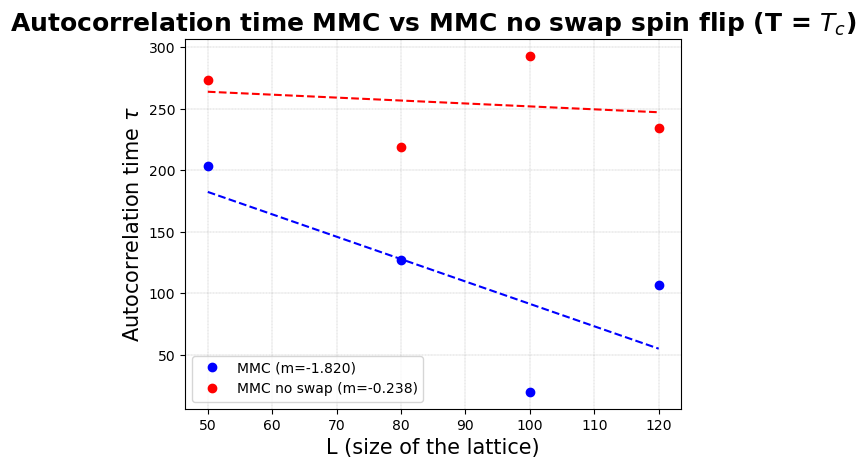

In [14]:
# Fit (tau vs L) straight line using linear regression
fit_MC = np.polyfit(lengths, tau_list_MC, 1)
fit_MNS = np.polyfit(lengths, tau_list_MNS, 1)

# Get the slopes (angular coefficients)
slope_MC = fit_MC[0]
slope_MNS = fit_MNS[0]

# Plot the data points and the fitted lines
plt.plot(lengths, tau_list_MC, 'bo', label=f'MMC (m={slope_MC:.3f})')
plt.plot(lengths, tau_list_MNS, 'ro', label=f'MMC no swap (m={slope_MNS:.3f})')
plt.plot(lengths, np.polyval(fit_MC, lengths), 'b--')
plt.plot(lengths, np.polyval(fit_MNS, lengths), 'r--')
#plt.yscale('log')
plt.title(r'Autocorrelation time MMC vs MMC no swap spin flip (T = $T_c$)', fontsize=18, fontweight='bold')
plt.xlabel('L (size of the lattice)', fontsize=15)
plt.ylabel(r'Autocorrelation time $\tau$', fontsize=15)
plt.grid(linestyle='--', linewidth=0.2, color='grey')
plt.legend()
plt.show()


In [15]:
lengths = [50, 80, 100, 120]
print('\nThe values of τ for each lattice size L for single spin flip is: \n')
for length, tau in zip(lengths, tau_list_MNS):
    print(f"Length {length}: τ = {tau:.3f}")



The values of τ for each lattice size L for single spin flip is: 

Length 50: τ = 273.783
Length 80: τ = 219.052
Length 100: τ = 293.055
Length 120: τ = 234.135


In [16]:
lengths = [50, 80, 100, 120]
print('\nThe values of τ for each lattice size L for MMC is: \n')
for length, tau in zip(lengths, tau_list_MC):
    print(f"Length {length}: τ = {tau:.3f}")


The values of τ for each lattice size L for MMC is: 

Length 50: τ = 203.285
Length 80: τ = 127.325
Length 100: τ = 19.946
Length 120: τ = 106.450


When swapping between adjacent chains is allowed, we observe that $\tau$, the autocorrelation time, is significantly smaller than in the case where swapping between chains is not allowed. Still, the integrated autocorrelation time is not completely satisfactory because in many case it is still of the order of magnitude of $10^2$.